<a href="https://colab.research.google.com/github/scw0310/ESAA/blob/main/2024-2%20project/ESAA_2024_2_%EB%B0%A9%ED%95%99%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_3_%ED%95%98%EB%82%A8%EA%B5%90%EC%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 하남시 전처리

### 유동인구

In [ ]:
# 하남시 격자데이터
grid = gpd.read_file("20.하남시_격자(100M).geojson")

In [ ]:
# 주중 유동인구 피처 생성
pop_week = pd.read_csv('19.하남시_요일별_유동인구.csv')

geometry = [Point(xy) for xy in zip(pop_week['lon'], pop_week['lat'])]
geo_pop_week = gpd.GeoDataFrame(pop_week, geometry=geometry, crs="EPSG:4326")

grid_pop_week = gpd.sjoin(geo_pop_week, grid, how='left', op='within').drop('index_right', axis=1)

grid_pop_week['STD_YM'] = grid_pop_week['STD_YM'].astype(str)
grid_pop_week['STD_YM'] = grid_pop_week['STD_YM'].str[:4]
grid_pop_week.rename(columns={'STD_YM': 'year'}, inplace=True)

In [ ]:
pop_week = grid_pop_week.groupby(['gid','year']).mean().reset_index()

# 주중/주말 유동인구 합계 계산
groups = {
    "주중_유동인구": ['mon_pop', 'tue_pop', 'wed_pop', 'thu_pop', 'fri_pop'],
    "주말_유동인구": ['sat_pop', 'sun_pop'],
}

for group_name, columns in groups.items():
    pop_week[f"{group_name}"] = pop_week[columns].sum(axis=1)

pop_week = pop_week[['gid', 'year','lon', 'lat', '주중_유동인구', '주말_유동인구']]
pop_week.head(2)

,gid,year,lon,lat,주중_유동인구,주말_유동인구
0,다사682452,2020,127.141153,37.506015,201.142917,37.923333
1,다사682452,2021,127.141153,37.506015,173.094167,30.773750


In [ ]:
merge_pop_week = pd.merge(grid, pop_week, how='left', on='gid')
merge_pop_week.head(2)

,gid,geometry,year,lon,lat,주중_유동인구,주말_유동인구
0,다사710491,"POLYGON ((127.17173 37.54077, 127.17173 37.541...",2020,127.172396,37.541259,198.085833,49.387083
1,다사710491,"POLYGON ((127.17173 37.54077, 127.17173 37.541...",2021,127.172396,37.541259,157.395833,39.058333


In [ ]:
pop_weekdays = merge_pop_week[['gid', 'geometry', 'year','lon', 'lat','주중_유동인구']]

pop_weekdays.head(2)

,gid,geometry,year,lon,lat,주중_유동인구
0,다사710491,"POLYGON ((127.17173 37.54077, 127.17173 37.541...",2020,127.172396,37.541259,198.085833
1,다사710491,"POLYGON ((127.17173 37.54077, 127.17173 37.541...",2021,127.172396,37.541259,157.395833


In [ ]:
pop_weekdays.to_csv('주중유동인구.csv', index=False)

유동인구 시각화

In [ ]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm

pop_weekdays = pop_weekdays.dropna(subset=['lat', 'lon', '주중_유동인구'])

# 히트맵 색상 정의
color_map = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'orange', 'red'],
    vmin=pop_weekdays['주중_유동인구'].min(),
    vmax=pop_weekdays['주중_유동인구'].max()
)

# 지도 생성
m = folium.Map(location=[37.5236, 127.2377], tiles='openstreetmap', zoom_start=12)

# 히트맵 추가
heat_data = [[row['lat'], row['lon'], row['주중_유동인구']] for _, row in pop_weekdays.iterrows()]
HeatMap(
    data=heat_data,
    radius=20,  # 반경 조정
    min_opacity=0.2,  # 최소 투명도
    max_zoom=15
).add_to(m)

color_map.caption = '유동인구 밀집도'
m.add_child(color_map)

# 지도 출력
m

### 버스정류장

In [ ]:
bus_stations = pd.read_csv('경기도 하남시_버스정류장 정보_20240911.csv',encoding="EUC-KR")

geometry = [Point(xy) for xy in zip(bus_stations['경도'], bus_stations['위도'])]
bus_stations_gdf = gpd.GeoDataFrame(bus_stations, geometry=geometry, crs="EPSG:4326")

bus_stations_grid = gpd.sjoin(bus_stations_gdf, grid, how='left', op='intersects').drop('index_right', axis=1)

bus_stations_grid.dropna(subset=['gid'], inplace=True)

bus_stations_grid.drop(['정류장약어명','위도', '경도'], axis=1, inplace=True)
bus_stations_grid.head()

,정류장아이디,정류장명,geometry,gid
299,227000508,골말사거리,POINT (127.19945 37.51767),다사734465
300,227000155,하산곡삼거리,POINT (127.22385 37.51480),다사755462
493,204000346,위례그린파크푸르지오,POINT (127.15461 37.47294),다사694415
512,204000192,웃논골,POINT (127.16651 37.46918),다사705411
541,204000237,위례호반써밋에비뉴,POINT (127.15426 37.47225),다사694415


In [ ]:
bus_grouped = bus_stations_grid.groupby('정류장아이디')['정류장명'].unique()
print('정류장 수 :', bus_stations_grid['정류장아이디'].nunique())

정류장 수 : 654


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
bus_stations_grid['정류장_encoded'] = encoder.fit_transform(bus_stations_grid['정류장아이디'])
print('인코딩 된 정류장 수 :', bus_stations_grid['정류장_encoded'].nunique())

인코딩 된 정류장 수 : 654


In [ ]:
bus_stations_grid.drop(['정류장아이디'], axis=1, inplace=True)

In [ ]:
from shapely import wkt
from matplotlib import font_manager, rc

import platform

# 한글 폰트 설정
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False


# 데이터 로드 및 변환
bus_stations_grid['geometry'] = bus_stations_grid['geometry'].apply(lambda x: wkt.loads(x) if isinstance(x, str) else x)

(127.13169793662776, 127.29348946612248, 37.46246750444903, 37.59837841921047)

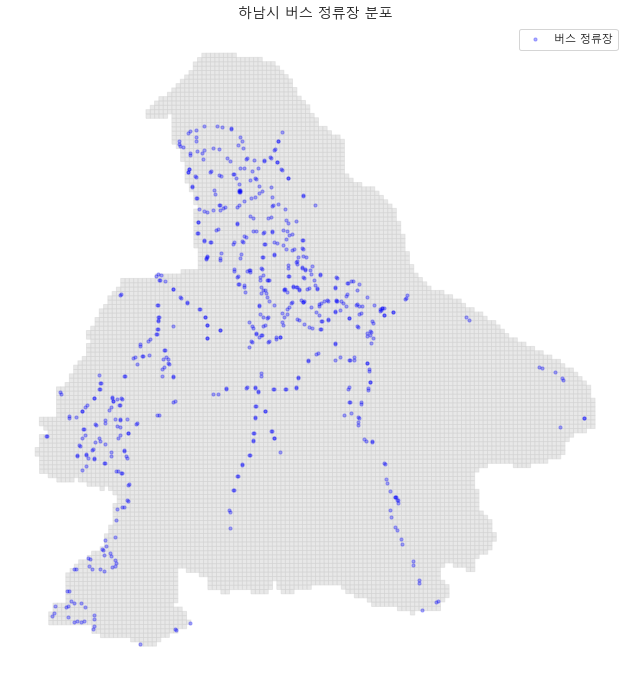

In [ ]:
# 시각화
fig, ax = plt.subplots(figsize=(12, 12))

grid.plot(ax=ax, color='lightgrey', edgecolor='lightgrey', alpha=0.5, label='하남시 격자')

bus_stations_grid[~bus_stations_grid['정류장_encoded'].isna()].plot(
    ax=ax, color='blue', marker='o', markersize=10, alpha=0.3, label='버스 정류장')

# 범례 추가
ax.legend()

# 제목 추가
ax.set_title('하남시 버스 정류장 분포', fontsize=14)

# 축 제거 (선택 사항)
ax.axis('off')

In [ ]:
bus_stations_grid['lon'] = bus_stations_grid.geometry.x
bus_stations_grid['lat'] = bus_stations_grid.geometry.y

In [ ]:
m = folium.Map(location=[37.5236, 127.2377], tiles='openstreetmap', zoom_start=12)

# 히트맵 데이터 생성
heat_data = [[row['lat'], row['lon']] for _, row in bus_stations_grid.iterrows()]

# HeatMap 추가
HeatMap(heat_data, radius=15, min_opacity=0.2, max_zoom=15).add_to(m)

# 지도 출력
m

### 상권1 : 발달상권

In [ ]:
com = pd.read_csv('발달상권현황.csv')
com.head(1)

,상권명,다중지역정보,업종정보,점포수,위도,경도
0,대산로,"{""type"":""Polygon"",""coordinates"":[[[126.7758903...",가정용 세탁업/두발 미용업/태권도 및 무술 교육기관/전자상거래 소매업/체인화 편의점...,46,37.669966,126.775159


In [ ]:
com.drop(['다중지역정보', '업종정보'], axis=1, inplace= True)
com.rename(columns={'점포수': '상권규모', '위도':'lat', '경도':'lon'}, inplace=True)

In [ ]:
geometry = [Point(xy) for xy in zip(com['lon'], com['lat'])]
com_gdf = gpd.GeoDataFrame(com, geometry=geometry, crs="EPSG:4326")

com_grid = gpd.sjoin(com_gdf, grid, how='left', op='intersects').drop('index_right', axis=1)

com_grid.dropna(subset=['gid'], inplace=True)

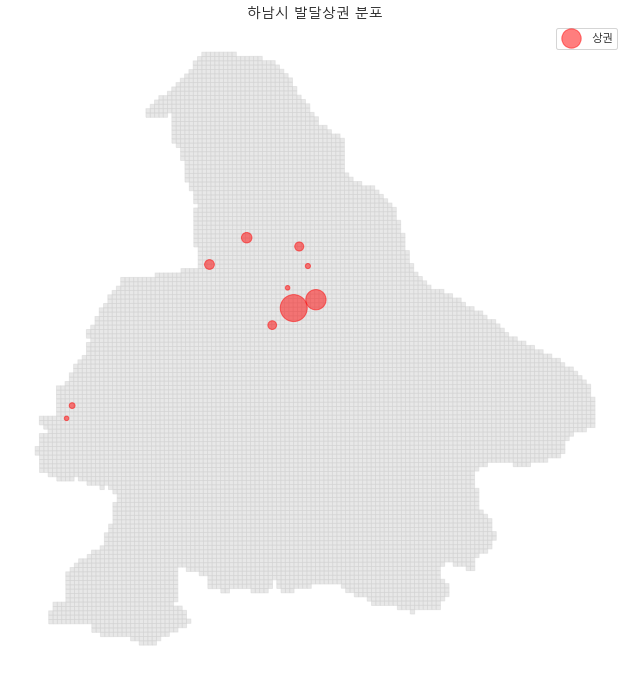

In [ ]:
# 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 성남시 격자 데이터 시각화 (배경)
grid.plot(ax=ax, color='lightgrey', edgecolor='lightgrey', alpha=0.5, label='성남시 격자')

# 상권 데이터 시각화
# 상권규모에 비례한 크기 계산
com_grid['점 크기'] = com_grid['상권규모'] * 1.5  # 상권규모에 맞춰 크기 설정 (배율 조정 가능)

# 상권규모가 NaN이 아닌 데이터만 표시
com_grid_filtered = com_grid[~com_grid['상권규모'].isna()]

# 상권 시각화
com_grid_filtered.plot(ax=ax, color='red', marker='o', markersize=com_grid_filtered['점 크기'],
    alpha=0.5,
    label='상권'
)

ax.legend()

# 제목 추가
ax.set_title('하남시 발달상권 분포', fontsize=14)

# 축 제거
ax.axis('off')

plt.show()

In [ ]:
m = folium.Map(location=[37.5236, 127.2377], tiles='openstreetmap', zoom_start=12)

# 히트맵 데이터 생성
heat_data = [[row['lat'], row['lon']] for _, row in com_grid.iterrows()]

# HeatMap 추가
HeatMap(heat_data, radius=15, min_opacity=0.2, max_zoom=15).add_to(m)

# 지도 출력
m

### 상권2 : 상권 전체

In [ ]:
com2 = pd.read_csv('행정동단위상가업소현황.csv')
com2.head(1)

,시군명,상호명,지번주소,도로명주소,위도,경도,신우편번호,지점명,상권업종대분류명,상권업종중분류명,상권업종소분류명,표준산업분류명,건물명
0,하남시,미사리풀하우스,경기도 하남시 미사동 27-3,경기도 하남시 미사동로40번길 274,37.561193,127.210916,12900,NaN,음식,한식,돼지고기 구이/찜,한식 육류 요리 전문점,NaN


In [ ]:
print(com2['상권업종대분류명'].unique())
print('\n',com2['상권업종중분류명'].unique())

['음식' '과학·기술' '소매' '수리·개인' '부동산' '교육' '시설관리·임대' '예술·스포츠' '숙박' '보건의료']

 ['한식' '인쇄·제품제작' '기타 생활용품 소매' '음료 소매' '자동차 수리·세차' '기술 서비스' '애완동물·용품 소매'
 '주점' '이용·미용' '부동산 서비스' '광고' '전문 디자인' '본사·경영 컨설팅' '종합 소매' '비알코올 ' '기타 교육'
 '청소·방제' '기타 간이' '식료품 소매' '섬유·의복·신발 소매' '의약·화장품 소매' '스포츠 서비스' '가전제품 수리'
 '도서관·사적지' '식물 소매' '여행사·보조' '가전·통신 소매' '일식' '세탁' '기타 숙박' '법무관련 '
 '기타 가정용품 수리' '안경·정밀기기 소매' '중식' '산업용품 대여' '연료 소매' '일반 교육' '기타 사업 서비스'
 '오락용품 소매' '가구 소매' '중고 상품 소매' '가정용품 대여' '사진 촬영' '유원지·오락' '동남아시아' '고용 알선'
 '의원' '컴퓨터 수리' '장식품 소매' '장례식장 ' '교육 지원' '철물·건설자재 소매' '일반 숙박' '수의'
 '운송장비 대여' '기타 전문 과학' '회계·세무' '자동차 부품 소매' '욕탕·신체관리' '시계·귀금속 소매' '기타 상품 소매'
 '구내식당·뷔페' '모터사이클 수리' '서양식' '모터사이클 소매' '담배 소매' '사무 지원' '시설관리' '조경·유지' '병원'
 '시장 조사' '기타 개인' '통신장비 수리' '기타 보건']


In [ ]:
com2.drop(['시군명', '도로명주소', '지점명', '상권업종중분류명', '상권업종소분류명', '표준산업분류명', '건물명'], axis=1, inplace= True)
com2.rename(columns={'위도':'lat', '경도':'lon'}, inplace=True)
com2.head(1)

,상호명,지번주소,lat,lon,신우편번호,상권업종대분류명
0,미사리풀하우스,경기도 하남시 미사동 27-3,37.561193,127.210916,12900,음식


In [ ]:
geometry = [Point(xy) for xy in zip(com2['lon'], com2['lat'])]
com2_gdf = gpd.GeoDataFrame(com2, geometry=geometry, crs="EPSG:4326")

com2_grid = gpd.sjoin(com2_gdf, grid, how='left', op='intersects').drop('index_right', axis=1)

com2_grid.dropna(subset=['gid'], inplace=True)

In [ ]:
# lat와 lon이 모두 일치하는 데이터 찾기
duplicate_rows = com_grid[com_grid.duplicated(subset=['lat', 'lon'], keep=False)]

# 결과 출력 : 없음
print(duplicate_rows)

Empty GeoDataFrame
Columns: [상권명, 상권규모, lat, lon, geometry, gid, 점 크기]
Index: []


<AxesSubplot:>

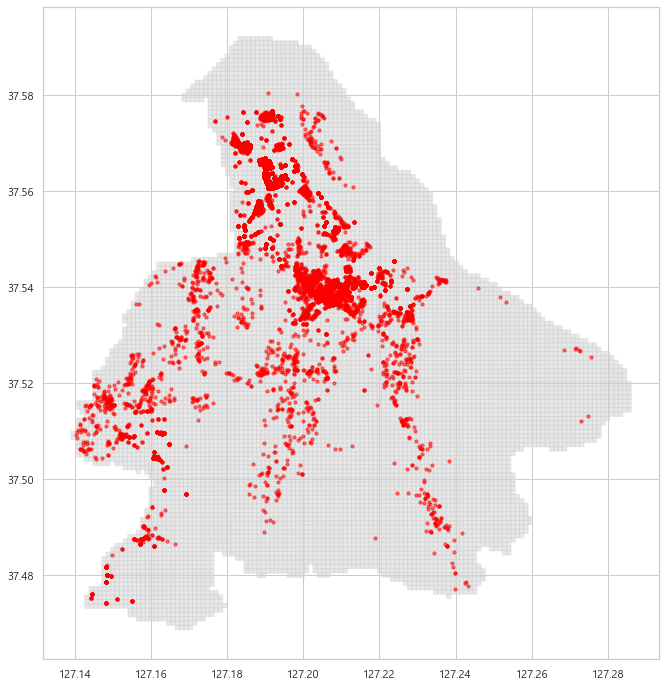

In [ ]:
# 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 성남시 격자 데이터 시각화 (배경)
grid.plot(ax=ax, color='lightgrey', edgecolor='lightgrey', alpha=0.5, label='성남시 격자')

# 상권
com2_grid[~com2_grid['상호명'].isna()].plot(
    ax=ax, color='red', marker='o', markersize=10, alpha=0.3, label='상권')

In [ ]:
m = folium.Map(location=[37.5236, 127.2377], tiles='openstreetmap', zoom_start=12)

# 히트맵 데이터 생성
heat_data = [[row['lat'], row['lon']] for _, row in com2_grid.iterrows()]

# HeatMap 추가
HeatMap(heat_data, radius=15, min_opacity=0.2, max_zoom=15).add_to(m)

# 지도 출력
m

### 영업일수

In [ ]:
행정동_영업일수 = pd.read_csv('행정동별_영업일수.csv')
행정동_영업일수.head(1)

,기준년도,기준분기,행정구역코드,행정구역명,운영점포평균영업기간,폐업점포평균영업기간,상권변동지표구분,상권변동지표구분명
0,2023,2,3110459,경기도 고양시 일산서구 송산동,77.9,58.1,LH,상권확장


In [ ]:
하남시_상가데이터 = pd.read_csv('하남시_상가현황.csv')
하남시_상가데이터.head(1)

,시군명,상호명,지번주소,도로명주소,위도,경도,신우편번호,지점명,상권업종대분류명,상권업종중분류명,상권업종소분류명,표준산업분류명,건물명
0,하남시,미사리풀하우스,경기도 하남시 미사동 27-3,경기도 하남시 미사동로40번길 274,37.561193,127.210916,12900,NaN,음식,한식,돼지고기 구이/찜,한식 육류 요리 전문점,NaN


In [ ]:
# 필요한 동 리스트
필요한_동 = ["천현동", "향동", "하사창동", "교산동", "상사창동",
            "춘궁동", "덕풍동", "창우동", "상산곡동", "광암동",
            "초일동", "초이동"]

# 지번주소에서 필요한 동만 필터링
하남시_상가데이터 = 하남시_상가데이터[
    하남시_상가데이터['지번주소'].str.contains('|'.join(필요한_동))
]

# 결과 확인
하남시_상가데이터.head(3)

,시군명,상호명,지번주소,도로명주소,위도,경도,신우편번호,지점명,상권업종대분류명,상권업종중분류명,상권업종소분류명,표준산업분류명,건물명
1,하남시,월드종합인쇄광고,경기도 하남시 덕풍동 339-15,경기도 하남시 하남대로861번안길 44-14,37.543243,127.200140,12971,NaN,과학·기술,인쇄·제품제작,명함/간판/광고물 제작,경 인쇄업,NaN
4,하남시,맑은유통,경기도 하남시 초일동 180,경기도 하남시 초일로213번길 42,37.536645,127.186553,12983,NaN,소매,음료 소매,생수/음료 소매업,음료 소매업,NaN
13,하남시,멜트디자인,경기도 하남시 덕풍동 833-1,경기도 하남시 미사대로 550,37.556765,127.206447,12925,NaN,과학·기술,전문 디자인,제품 디자인업,제품 디자인업,현대지식산업센터한강미사


In [ ]:
# 남기고 싶은 칼럼 리스트
columns_to_keep = ["지번주소", "도로명주소", "위도", "경도"]

# 원하는 칼럼만 남기기
하남시_상가데이터 = 하남시_상가데이터[columns_to_keep]

격자매핑

In [ ]:
geometry = [Point(xy) for xy in zip(하남시_상가데이터['경도'], 하남시_상가데이터['위도'])]
df_geo_하남시_상가데이터= gpd.GeoDataFrame(하남시_상가데이터, geometry=geometry, crs="EPSG:4326")
grid_하남시_상가데이터 = gpd.sjoin(df_geo_하남시_상가데이터, grid, how='left', op='within').drop('index_right', axis=1)
grid_하남시_상가데이터.head(1)

,지번주소,도로명주소,위도,경도,geometry,gid
1,경기도 하남시 덕풍동 339-15,경기도 하남시 하남대로861번안길 44-14,37.543243,127.20014,POINT (127.20014 37.54324),다사735493


In [ ]:
# 필요한 동 리스트
필요한_동 = ["천현동", "향동", "하사창동", "교산동", "상사창동",
            "춘궁동", "덕풍동", "창우동", "상산곡동", "광암동",
            "초일동", "초이동"]

# 지번주소에서 필요한 동만 필터링
행정동_영업일수 = 행정동_영업일수[
    행정동_영업일수['행정구역명'].str.contains('|'.join(필요한_동))
]

# 결과 확인
하남시_상가데이터.head(3)

,지번주소,도로명주소,위도,경도,geometry
1,경기도 하남시 덕풍동 339-15,경기도 하남시 하남대로861번안길 44-14,37.543243,127.200140,POINT (127.20014 37.54324)
4,경기도 하남시 초일동 180,경기도 하남시 초일로213번길 42,37.536645,127.186553,POINT (127.18655 37.53664)
13,경기도 하남시 덕풍동 833-1,경기도 하남시 미사대로 550,37.556765,127.206447,POINT (127.20645 37.55677)


In [ ]:
# 남기고 싶은 칼럼 리스트
columns_to_keep = ["행정구역명", "운영점포평균영업기간", "폐업점포평균영업기간"]

# 원하는 칼럼만 남기기
행정동_영업일수 = 행정동_영업일수[columns_to_keep]

In [ ]:
행정동_영업일수.groupby("행정구역명").mean()

,운영점포평균영업기간,폐업점포평균영업기간
행정구역명,,
경기도 하남시 천현동,99.957143,74.250000
경기도 하남시 초이동,109.716667,68.833333
경기도 하남시 춘궁동,103.635714,68.042857


### 동별 개별공시지가

In [ ]:
하남시_개별공시지가 = pd.read_csv('경기도 하남시_개별공시지가_20240430.csv')
하남시_개별공시지가.head(1)

,연번,법정동,코드,구분,본번,부번,결정지가,기준일자,공시일자
0,1,천현동,10100,일반,157,4,4527000,2024-01-01,2024-04-30


In [ ]:
# 필요한 동 리스트
필요한_동 = ["천현동", "향동", "하사창동", "교산동", "상사창동",
            "춘궁동", "덕풍동", "창우동", "상산곡동", "광암동",
            "초일동", "초이동"]

# 지번주소에서 필요한 동만 필터링
하남시_개별공시지가 = 하남시_개별공시지가[
    하남시_개별공시지가['법정동'].str.contains('|'.join(필요한_동))
]

# 결과 확인
하남시_개별공시지가.head(3)

,연번,법정동,코드,구분,본번,부번,결정지가,기준일자,공시일자
0,1,천현동,10100,일반,157,4,4527000,2024-01-01,2024-04-30
1,2,천현동,10100,일반,194,2,3300000,2024-01-01,2024-04-30
2,3,천현동,10100,일반,194,6,4302000,2024-01-01,2024-04-30


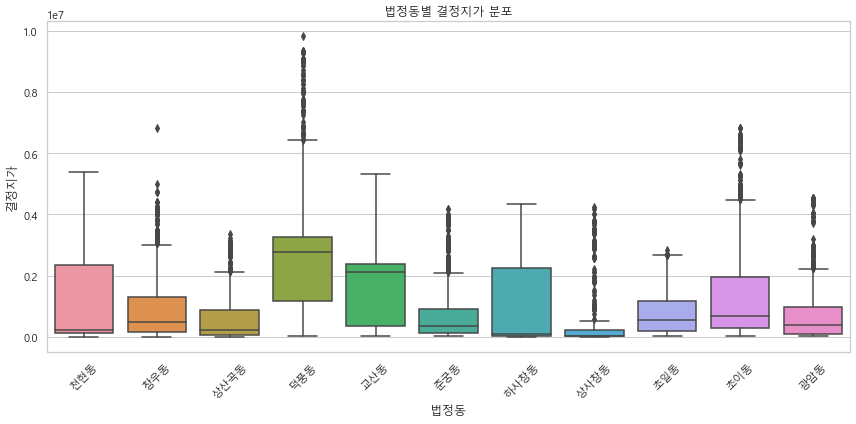

In [ ]:
# 시각화: 법정동별 결정지가 분포
plt.figure(figsize=(12, 6))
sns.boxplot(x='법정동', y='결정지가', data=하남시_개별공시지가)
plt.xticks(rotation=45)
plt.title('법정동별 결정지가 분포')
plt.xlabel('법정동')
plt.ylabel('결정지가')
plt.tight_layout()
plt.show()